In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import imblearn.over_sampling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve, roc_auc_score, classification_report, precision_recall_curve, f1_score
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import ExtraTreesClassifier 
import xgboost as xgb
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import warnings 
warnings.filterwarnings(action= 'ignore')

# EDA 

Starting by joining the Billboard top 100 dataset and the Spotify dataset

## Importing Spotify dataset

In [2]:
spotify_songs = pd.read_csv('all_songs_data.csv')

#cleaning the artist and songs columns to match with the billboard data set

spotify_songs['Artist'] = spotify_songs['Artist'].str.lstrip("&").str.lower().str.replace(' ','')

spotify_songs['Song'] = spotify_songs['Song'].str.lower()

#check the shape
spotify_songs.shape

(13377, 22)

## Removing Duplicates

sometimes the song can appear in diffrent playlists so we need to remove the duplicated songs by their IDs 

In [3]:
#check for duplicate songs 
spotify_songs['Id'].nunique()

13006

In [4]:
#lets drop them
spotify_songs= spotify_songs.drop_duplicates(subset=['Id'])

spotify_songs.shape

(13006, 22)

## Importing Billboard dataset

In [5]:
billboard_charts = pd.read_csv('100_charts.csv')

#drop columns we dont need 
billboard_charts = billboard_charts.drop(['Unnamed: 0','Date'],axis = 1)

billboard_charts.shape

(330587, 3)

In [6]:
billboard_charts_grouped = pd.DataFrame(billboard_charts.groupby(['artist','song'],as_index=False)['peakPos_'].min())
billboard_charts_grouped

,artist,song,peakPos_
0,"""Groove"" Holmes",Misty,44
1,"""Groove"" Holmes",What Now My Love,96
2,"""Little"" Jimmy Dickens",May The Bird Of Paradise Fly Up Your Nose,15
3,"""Pookie"" Hudson",I Know I Know,96
4,"""Weird Al"" Yankovic",Amish Paradise,53
...,...,...,...
29655,will.i.am & Nicki Minaj,Check It Out,24
29656,will.i.am Featuring Justin Bieber,#thatPOWER,17
29657,will.i.am Featuring Mick Jagger & Jennifer Lopez,T.H.E (The Hardest Ever),36
29658,will.i.am Featuring Miley Cyrus,Fall Down,58


In [7]:
# Clean the billboard columns because it is a mess to match with the columns in the spotify dataset 

billboard_charts_grouped['artist'] = billboard_charts_grouped['artist'].str.lower().str.replace('featuring','&').str.replace('ft.','&').str.replace('ft','&').str.replace('feature','&').str.replace('feat.','&').str.replace('feat','&').str.replace('+','&').str.replace('with','&').str.replace('/','&').str.replace(',','&').str.replace(' ','')\
.str.replace('(','').str.replace(')','')

billboard_charts_grouped['song'] = billboard_charts_grouped['song'].str.lower()

billboard_charts_grouped.sample(2)

,artist,song,peakPos_
10819,heart,dog + butterfly,34
2169,berlin,the metro,58


## Merging 

we have the *song* and *artist* from the billborad and we have *Song* and *Artist* from the Spotify dataset.. so we will merge on them lets call it *hit_songs*

In [8]:
hit_songs = pd.merge(billboard_charts_grouped,spotify_songs, how='inner', left_on=['song','artist'], right_on = ['Song','Artist'])

hit_songs.head()

,artist,song,peakPos_,Unnamed: 0,Song,Artist,Id,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,10years,wasteland,94,1708,wasteland,10years,0nTiC2fGkM4q8bGlBKGrGx,0.404,0.797,6.0,...,0.0824,0.361,146.580,audio_features,0nTiC2fGkM4q8bGlBKGrGx,spotify:track:0nTiC2fGkM4q8bGlBKGrGx,https://api.spotify.com/v1/tracks/0nTiC2fGkM4q...,https://api.spotify.com/v1/audio-analysis/0nTi...,229973.0,4.0
1,10cc,dreadlock holiday,44,1940,dreadlock holiday,10cc,5SI6jYhKUWm1qnaheTm4Zw,0.837,0.380,7.0,...,0.1980,0.892,104.995,audio_features,5SI6jYhKUWm1qnaheTm4Zw,spotify:track:5SI6jYhKUWm1qnaheTm4Zw,https://api.spotify.com/v1/tracks/5SI6jYhKUWm1...,https://api.spotify.com/v1/audio-analysis/5SI6...,267947.0,4.0
2,10cc,dreadlock holiday,44,2771,dreadlock holiday,10cc,1LOZMYF5s8qhW7Rv4w2gun,0.837,0.380,7.0,...,0.1980,0.892,104.995,audio_features,1LOZMYF5s8qhW7Rv4w2gun,spotify:track:1LOZMYF5s8qhW7Rv4w2gun,https://api.spotify.com/v1/tracks/1LOZMYF5s8qh...,https://api.spotify.com/v1/audio-analysis/1LOZ...,267947.0,4.0
3,10cc,good morning judge,69,2660,good morning judge,10cc,1fMGRxKRtIKNyaMMGrzInM,0.737,0.642,9.0,...,0.0726,0.467,106.742,audio_features,1fMGRxKRtIKNyaMMGrzInM,spotify:track:1fMGRxKRtIKNyaMMGrzInM,https://api.spotify.com/v1/tracks/1fMGRxKRtIKN...,https://api.spotify.com/v1/audio-analysis/1fMG...,174667.0,4.0
4,10cc,i'm mandy fly me,60,2593,i'm mandy fly me,10cc,4mmWv18Tz155oy6x7PEe3q,0.426,0.546,7.0,...,0.0966,0.440,107.885,audio_features,4mmWv18Tz155oy6x7PEe3q,spotify:track:4mmWv18Tz155oy6x7PEe3q,https://api.spotify.com/v1/tracks/4mmWv18Tz155...,https://api.spotify.com/v1/audio-analysis/4mmW...,323533.0,3.0


In [9]:
hit_songs.drop(['Unnamed: 0','Song','Artist','Id'],axis = 1,inplace = True)

## Labeling 

we need to add a new column called *Hit or not* that will check if the song's ID is on the *hit_Songs* then add a label 1 (Hit)
otherwise add 0 (Not Hit)

In [10]:
hit_id = list(hit_songs['id'])

In [11]:
# Now getting the not hit songs :

spotify_songs['Hit or not'] = np.where(spotify_songs['Id'].isin(hit_id), '1', '0')

spotify_songs = spotify_songs.drop(['Unnamed: 0','Id'],axis=1)

In [12]:
spotify_songs = spotify_songs.dropna()

In [13]:
spotify_songs = spotify_songs.astype({'Hit or not': 'int32'})
spotify_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13003 entries, 0 to 13376
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song              13003 non-null  object 
 1   Artist            13003 non-null  object 
 2   danceability      13003 non-null  float64
 3   energy            13003 non-null  float64
 4   key               13003 non-null  float64
 5   loudness          13003 non-null  float64
 6   mode              13003 non-null  float64
 7   speechiness       13003 non-null  float64
 8   acousticness      13003 non-null  float64
 9   instrumentalness  13003 non-null  float64
 10  liveness          13003 non-null  float64
 11  valence           13003 non-null  float64
 12  tempo             13003 non-null  float64
 13  type              13003 non-null  object 
 14  id                13003 non-null  object 
 15  uri               13003 non-null  object 
 16  track_href        13003 non-null  object

## Get a look into the data

As shown in the graph below, we can clearly see that class 0 ( Not hit ) have higher density than class 1 (Hit) and thats because of imbalance dataset ..

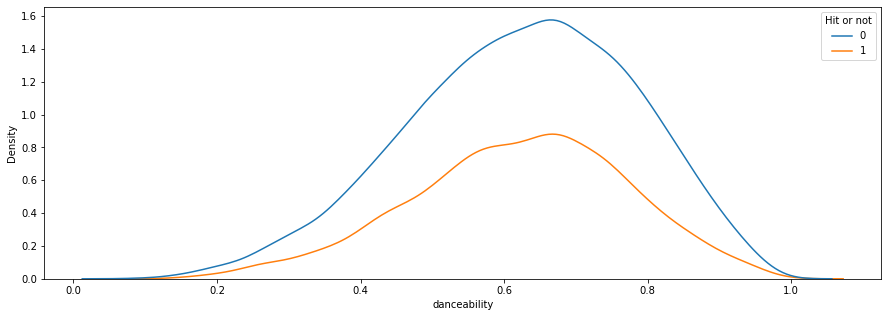

In [14]:
plt.figure(figsize=(15,5))
sns.kdeplot(data=spotify_songs, x="danceability", hue="Hit or not");


As we can see, the 0 (not Hit) class is almost double the 1 (Hit) class

In [15]:
spotify_songs['Hit or not'].value_counts()

0    8613
1    4390
Name: Hit or not, dtype: int64

The pair plot shows that the data is imbalanced and there is no linear relationship 

In [ ]:
feature_names_pp = ['danceability', 'energy', 'key', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms','Hit or not']

sns.pairplot(spotify_songs[feature_names_pp], hue='Hit or not');

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(9, 1,figsize=(10,20),constrained_layout=True)


feature_names_pp = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

sns.boxplot(data=spotify_songs['energy'], orient="h", ax= axes[0] ,palette="Set2").set_title("Energy", fontsize=16)
sns.boxplot(data=spotify_songs['danceability'], orient="h", ax= axes[1] ,palette="Set2").set_title("Danceability", fontsize=16)
sns.boxplot(data=spotify_songs['loudness'], orient="h", ax= axes[2] ,palette="Set2").set_title("Loudness", fontsize=16)
sns.boxplot(data=spotify_songs['speechiness'], orient="h", ax= axes[3] ,palette="Set2").set_title("Speechiness", fontsize=16)
sns.boxplot(data=spotify_songs['acousticness'], orient="h", ax= axes[4] ,palette="Set2").set_title("Acousticness", fontsize=16)
sns.boxplot(data=spotify_songs['instrumentalness'], orient="h", ax= axes[5] ,palette="Set2").set_title("Instrumentalness", fontsize=16)
sns.boxplot(data=spotify_songs['liveness'], orient="h", ax= axes[6] ,palette="Set2").set_title("Liveness", fontsize=16)
sns.boxplot(data=spotify_songs['valence'], orient="h", ax= axes[7] ,palette="Set2").set_title("Valence", fontsize=16)
sns.boxplot(data=spotify_songs['tempo'], orient="h", ax= axes[8] ,palette="Set2").set_title("Tempo", fontsize=16)


We can see the boxplots for each feature, it seems fine.. no crazy outliers. 
In fact, the outliers that appear in the boxplot aren't actual outliers, they're values of features uniquely characteristic for each song, and removal of such values will not rid us of outliers; instead, it'll get rid of relevant and important rows of data.

# Handeling imbalance 


##  1. Imbalance data with the baseline model

even though we have an imbalance dataset we first need to test its performance.. so i think logistic regression is a good model to start with. 

In [ ]:
# First lets split the data 

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = spotify_songs[feature_names]

Y = spotify_songs['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)


In [ ]:
#transform the data
std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [ ]:
lr = LogisticRegression(solver='liblinear')

lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

In [ ]:
print(classification_report(Y_test, Y_pred))

This is super bad.. the model is doing a terrible job at predicting the target class (Hit) but this is clearly because of the imbalance data. Also, we wont be happy with the 0.66 accuracy because it is not a good performance measure when it comes to imbalanced data 

## 2. Oversampling

### Random Oversampling

- Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.

- Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

- Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

In [ ]:
#taking a random sample from the 

n_hit = np.sum(Y_train == 1)
n_nothit = np.sum(Y_train == 0)
ratio = {1 : n_hit * 2, 0 : n_nothit}

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = "not majority", random_state=42) 

X_tr_rs, y_tr_rs = ROS.fit_resample(X_train,Y_train)

In [ ]:
lr = LogisticRegression(solver='liblinear')

lr.fit(X_tr_rs, y_tr_rs)

Y_pred = lr.predict(X_test)

print(classification_report(Y_test, Y_pred))

We can see some improvment in the F1 score for both classes and it seems more normal.

 it happend because LR is not a good model for our data becuse there is no linear relationship between the features and the traget,  so i will try diffrent models too 

In [ ]:
# fitting as much models we want , i wont use knn too because it will perform the same as LR

lr_rs = LogisticRegression(solver='liblinear')

lr_rs.fit(X_tr_rs, y_tr_rs)

xgb_rs = XGBClassifier()

xgb_rs.fit(X_tr_rs, y_tr_rs)

rfc_rs = RandomForestClassifier()

rfc_rs.fit(X_tr_rs,y_tr_rs)

ada_rs = AdaBoostClassifier()

ada_rs.fit(X_tr_rs,y_tr_rs)


In [ ]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_rs,xgb_rs,lr_rs,ada_rs]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using Random Oversampling');

Based on the ROC graph, we can see that the AUC is the highest for the Random forset classifier and the F1 score is better. but lets try SMOT.

In [ ]:
Y_pred = rfc_rs.predict(X_test)

print(classification_report(Y_test, Y_pred))

### SMOT Oversampling


In [ ]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='not majority', random_state = 42)

X_smote, y_smote = smote.fit_resample(X_train, Y_train)


lr_sm = LogisticRegression(solver='liblinear')

lr_sm.fit(X_smote, y_smote)

xgb_sm = XGBClassifier()

xgb_sm.fit(X_smote, y_smote)

rfc_sm = RandomForestClassifier()

rfc_sm.fit(X_smote, y_smote)

ada_sm = AdaBoostClassifier()

ada_sm.fit(X_smote, y_smote)



In [ ]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_sm,xgb_sm,ada_sm,lr_sm]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using SMOTE');

In [ ]:
Y_pred = rfc_sm.predict(X_test)

print(classification_report(Y_test, Y_pred))

## 3. Undersampling 

In [ ]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority',random_state = 42)

X_tr_ur, y_tr_ur = under.fit_resample(X_train, Y_train)

In [ ]:
y_tr_ur.value_counts()

In [ ]:
lr_u = LogisticRegression(solver='liblinear')

lr_u.fit(X_tr_ur, y_tr_ur)

xgb_u = XGBClassifier()

xgb_u.fit(X_tr_ur, y_tr_ur)

rfc_u = RandomForestClassifier(random_state=42,n_estimators= 100, max_depth=10)

rfc_u.fit(X_tr_ur, y_tr_ur)

ada_u = AdaBoostClassifier()

ada_u.fit(X_tr_ur, y_tr_ur)

In [ ]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_u,xgb_u,ada_u,lr_u]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using undersampling');

In [ ]:
Y_pred = rfc_u.predict(X_test)

print(classification_report(Y_test, Y_pred))

## Undersampling without RandomUnderSampler

In [ ]:
min_class_len = len(spotify_songs[spotify_songs['Hit or not']== 1])
min_class_len

In [ ]:
maj_class_index = spotify_songs[spotify_songs['Hit or not']== 0].index
len(maj_class_index)

In [ ]:
random_maj_index = np.random.choice(maj_class_index,min_class_len, replace= False)

print(len(random_maj_index))

In [ ]:
min_class_index = spotify_songs[spotify_songs['Hit or not']== 1].index

In [ ]:
under_sample_index = np.concatenate([min_class_index,random_maj_index])

In [ ]:
under_sample_df = spotify_songs.loc[under_sample_index]

In [ ]:
under_sample_df['Hit or not'].value_counts()

In [ ]:
# First lets split the data 

feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = under_sample_df[feature_names]
Y = under_sample_df['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
#transform the data

std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [ ]:
rfc1 = RandomForestClassifier(random_state=42,n_estimators= 100, max_depth=2)

rfc1.fit(X_train, Y_train)

Y_pred = rfc1.predict(X_test)

print(classification_report(Y_test, Y_pred))

# Feature Engineering (Artist feautres)

 What if we add one more feature ( 3 in fact )? if the model get the artisit behiend the scuess of the song or not?

In [ ]:
new = spotify_songs['Artist'].str.split("&", n = 2, expand = True)

spotify_songs['Artist1']= new[0]
 
spotify_songs['Artist2']= new[1]

spotify_songs['Artist3']= new[2]

spotify_songs.drop(columns =["Artist"], inplace = True)

In [ ]:
le = LabelEncoder()
spotify_songs['Artist1'] = le.fit_transform(spotify_songs['Artist1'])
spotify_songs['Artist2'] = le.fit_transform(spotify_songs['Artist2'])
spotify_songs['Artist3'] = le.fit_transform(spotify_songs['Artist3'])
spotify_songs.head()

## More features with imbalance data

In [47]:
# First lets split the data 

feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = spotify_songs[feature_names]

Y = spotify_songs['Hit or not']

X_train_FE, X_test_FE, Y_train_FE, Y_test_FE = train_test_split(X, Y, test_size=0.2, random_state=8)

In [48]:
#transform the data
std = StandardScaler()
std.fit(X_train_FE.values)
X_train_FE = std.transform(X_train_FE.values)
X_test_FE = std.transform(X_test_FE.values)

In [49]:
rfc_fe = RandomForestClassifier()

rfc_fe.fit(X_train_FE,Y_train_FE)

Y_pred = rfc_fe.predict(X_test_FE)

print(classification_report(Y_test_FE, Y_pred))


              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1720
           1       0.67      0.29      0.40       881

    accuracy                           0.71      2601
   macro avg       0.69      0.61      0.61      2601
weighted avg       0.70      0.71      0.67      2601



we all ready have promising results, but the recall score is very low for the 1 (Hit) class and our goal is to reduce it. this is happing because of the imbalance data.. so lets try resampling methods

## More features with resampling methods 

### SMOT Oversampling 

In [50]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='not majority', random_state = 42)

X_smote, y_smote = smote.fit_resample(X_train_FE, Y_train_FE)


lr_sm = LogisticRegression(solver='liblinear')

lr_sm.fit(X_smote, y_smote)

xgb_sm = XGBClassifier()

xgb_sm.fit(X_smote, y_smote)

rfc_sm = RandomForestClassifier()

rfc_sm.fit(X_smote, y_smote)

ada_sm = AdaBoostClassifier()

ada_sm.fit(X_smote, y_smote)


[20:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

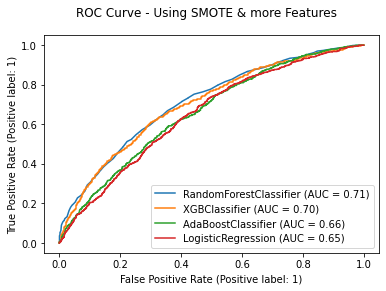

In [51]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_sm,xgb_sm,ada_sm,lr_sm]:
    metrics.plot_roc_curve(mod, X_test_FE, Y_test_FE, ax=ax1)
plt.suptitle('ROC Curve - Using SMOTE & more Features');

In [52]:
Y_pred = rfc_sm.predict(X_test_FE)

print(classification_report(Y_test_FE, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1720
           1       0.54      0.51      0.53       881

    accuracy                           0.69      2601
   macro avg       0.65      0.65      0.65      2601
weighted avg       0.68      0.69      0.69      2601



This is better, but i think undersampling methods will get better results. 

### Random UnderSampler

In [53]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority',random_state = 42)

X_tr_ur, y_tr_ur = under.fit_resample(X_train_FE, Y_train_FE)

In [54]:
y_tr_ur.value_counts()

0    3509
1    3509
Name: Hit or not, dtype: int64

In [55]:
lr_u = LogisticRegression(solver='liblinear')

lr_u.fit(X_tr_ur, y_tr_ur)

xgb_u = XGBClassifier()

xgb_u.fit(X_tr_ur, y_tr_ur)

rfc_u = RandomForestClassifier()

rfc_u.fit(X_tr_ur, y_tr_ur)

ada_u = AdaBoostClassifier()

ada_u.fit(X_tr_ur, y_tr_ur)

[20:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

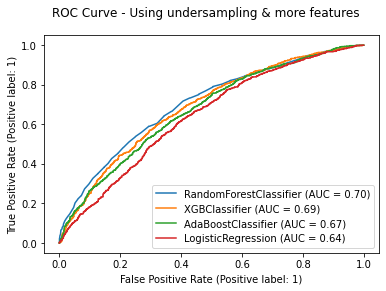

In [57]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_u,xgb_u,ada_u,lr_u]:
    metrics.plot_roc_curve(mod, X_test_FE, Y_test_FE, ax=ax1)
plt.suptitle('ROC Curve - Using undersampling & more features');

In [58]:
Y_pred = rfc_u.predict(X_test_FE)


print(classification_report(Y_test_FE, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1720
           1       0.48      0.67      0.56       881

    accuracy                           0.64      2601
   macro avg       0.63      0.65      0.63      2601
weighted avg       0.68      0.64      0.65      2601



### without Randon UnderSampler

In [60]:
min_class_len = len(spotify_songs[spotify_songs['Hit or not']== 1])
min_class_len

4390

In [61]:
maj_class_index = spotify_songs[spotify_songs['Hit or not']== 0].index
len(maj_class_index)

8613

In [62]:
random_maj_index = np.random.choice(maj_class_index,min_class_len, replace= False)

print(len(random_maj_index))

4390


In [63]:
min_class_index = spotify_songs[spotify_songs['Hit or not']== 1].index

In [64]:
under_sample_index = np.concatenate([min_class_index,random_maj_index])

In [65]:
under_sample_df = spotify_songs.loc[under_sample_index]

In [66]:
under_sample_df['Hit or not'].value_counts()

1    4390
0    4390
Name: Hit or not, dtype: int64

In [72]:
feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = under_sample_df[feature_names]
Y = under_sample_df['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [73]:
#transform the data

std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [74]:
lr_um = LogisticRegression(solver='liblinear')

lr_um.fit(X_train, Y_train)

xgb_um = XGBClassifier()

xgb_um.fit(X_train, Y_train)

rfc_um = RandomForestClassifier()

rfc_um.fit(X_train, Y_train)

ada_um= AdaBoostClassifier()

ada_um.fit(X_train, Y_train)

[20:52:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

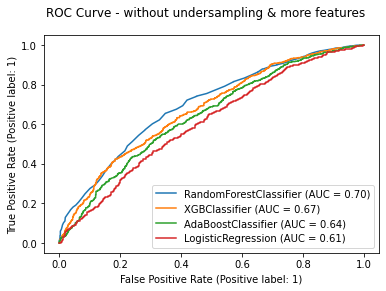

In [75]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_um,xgb_um,ada_um,lr_um]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - without undersampling & more features');

In [76]:
rfc_fe = RandomForestClassifier()

rfc_fe.fit(X_train,Y_train)

Y_pred = rfc_fe.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       863
           1       0.66      0.64      0.65       893

    accuracy                           0.65      1756
   macro avg       0.65      0.65      0.65      1756
weighted avg       0.65      0.65      0.65      1756



# What about adding more songs? +more  EDA

In [2]:
spotify_songs_added = pd.read_csv('more_songs_data.csv')
spotify_songs_added.head()

,Unnamed: 0,Song,Artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Hit or not
0,0,Walking Blues,bigjoewilliams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827,0.00206,0.0756,0.640,101.157,161893,4,0
1,1,Suddenly Last Summer,themotels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162,0.03060,0.0831,0.561,120.141,222000,4,1
2,2,Sanctuary,bélafleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368,0.16500,0.1160,0.803,116.831,444907,4,0
3,3,The Wild Rover,thepogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585,0.00000,0.0720,0.880,97.500,157893,3,0
4,4,In The Driver's Seat,johnschneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375,0.00000,0.1800,0.764,163.351,162293,4,1


In [3]:
spotify_songs_added.shape

(25431, 18)

In [4]:
spotify_songs_added['uri'].nunique()

24119

In [5]:
#lets drop them
spotify_songs_added= spotify_songs_added.drop_duplicates(subset=['uri'])

spotify_songs_added.shape

(24119, 18)

In [6]:
spotify_songs_added['Hit or not'].value_counts()

0    14512
1     9607
Name: Hit or not, dtype: int64

In [7]:
new = spotify_songs_added['Artist'].str.split("&", n = 2, expand = True)

spotify_songs_added['Artist1']= new[0]
 
spotify_songs_added['Artist2']= new[1]

spotify_songs_added['Artist3']= new[2]

spotify_songs_added.drop(columns =["Artist"], inplace = True)

In [8]:
le = LabelEncoder()
spotify_songs_added['Artist1'] = le.fit_transform(spotify_songs_added['Artist1'])
spotify_songs_added['Artist2'] = le.fit_transform(spotify_songs_added['Artist2'])
spotify_songs_added['Artist3'] = le.fit_transform(spotify_songs_added['Artist3'])
spotify_songs_added.head()

,Unnamed: 0,Song,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Hit or not,Artist1,Artist2,Artist3
0,0,Walking Blues,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827,0.00206,0.0756,0.640,101.157,161893,4,0,720,1690,577
1,1,Suddenly Last Summer,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162,0.03060,0.0831,0.561,120.141,222000,4,1,6464,1690,577
2,2,Sanctuary,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368,0.16500,0.1160,0.803,116.831,444907,4,0,1055,1690,577
3,3,The Wild Rover,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585,0.00000,0.0720,0.880,97.500,157893,3,0,6512,1690,577
4,4,In The Driver's Seat,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375,0.00000,0.1800,0.764,163.351,162293,4,1,3189,1690,577


In [9]:
spotify_songs_added.columns

Index(['Unnamed: 0', 'Song', 'uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'Hit or not', 'Artist1', 'Artist2', 'Artist3'],
      dtype='object')

## SMOT Oversampling (More data)

In [10]:
# First lets split the data 

feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = spotify_songs_added[feature_names]

Y = spotify_songs_added['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

In [11]:
std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [12]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='not majority', random_state = 42)

X_smote, y_smote = smote.fit_resample(X_train, Y_train)


lr_sm = LogisticRegression(solver='liblinear')

lr_sm.fit(X_smote, y_smote)

xgb_sm = XGBClassifier()

xgb_sm.fit(X_smote, y_smote)

rfc_sm = RandomForestClassifier()

rfc_sm.fit(X_smote, y_smote)

ada_sm = AdaBoostClassifier()

ada_sm.fit(X_smote, y_smote)

gnb_sm = GaussianNB()

gnb_sm.fit(X_smote, y_smote)

svm_sm = svm.SVC(gamma='auto', probability=True)

svm_sm.fit(X_smote, y_smote)

[08:33:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SVC(gamma='auto', probability=True)

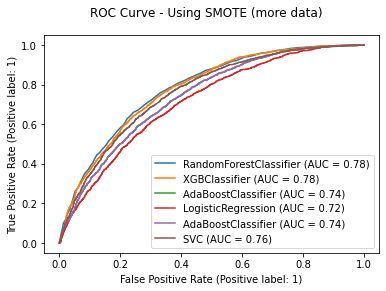

In [13]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_sm,xgb_sm,ada_sm,lr_sm,ada_sm,svm_sm]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using SMOTE (more data)');

In [14]:
Y_pred = rfc_sm.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      2870
           1       0.64      0.67      0.65      1954

    accuracy                           0.71      4824
   macro avg       0.70      0.71      0.71      4824
weighted avg       0.72      0.71      0.71      4824



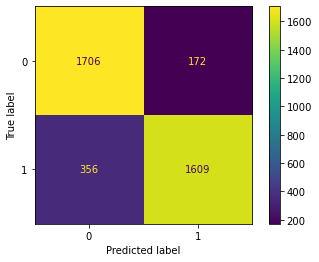

In [35]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc_sm, X_test, Y_test)

## Random Undersampling 

In [15]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority',random_state = 42)

X_tr_ur, y_tr_ur = under.fit_resample(X_train, Y_train)

In [16]:
y_tr_ur.value_counts()

0    7653
1    7653
Name: Hit or not, dtype: int64

In [17]:
lr_u = LogisticRegression(solver='liblinear')

lr_u.fit(X_tr_ur, y_tr_ur)

xgb_u = XGBClassifier()

xgb_u.fit(X_tr_ur, y_tr_ur)

rfc_u = RandomForestClassifier()

rfc_u.fit(X_tr_ur, y_tr_ur)

ada_u = AdaBoostClassifier()

ada_u.fit(X_tr_ur, y_tr_ur)

[08:36:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

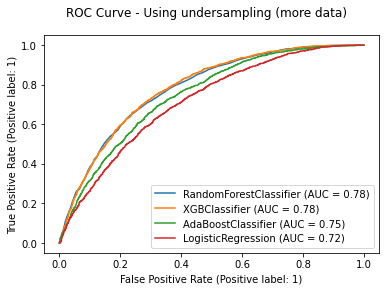

In [18]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_u,xgb_u,ada_u,lr_u]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using undersampling (more data)');

In [19]:
Y_pred = rfc_u.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      2870
           1       0.62      0.72      0.67      1954

    accuracy                           0.71      4824
   macro avg       0.70      0.71      0.70      4824
weighted avg       0.72      0.71      0.71      4824



## Without Random under sampling  ( manually)

In [20]:
min_class_len = len(spotify_songs_added[spotify_songs_added['Hit or not']== 1])
min_class_len

9607

In [21]:
maj_class_index = spotify_songs_added[spotify_songs_added['Hit or not']== 0].index
len(maj_class_index)

14512

In [22]:
random_maj_index = np.random.choice(maj_class_index,min_class_len, replace= False)

print(len(random_maj_index))

9607


In [23]:
min_class_index = spotify_songs_added[spotify_songs_added['Hit or not']== 1].index

In [24]:
under_sample_index = np.concatenate([min_class_index,random_maj_index])

In [25]:
under_sample_df = spotify_songs_added.loc[under_sample_index]

In [26]:
under_sample_df['Hit or not'].value_counts()

0    9607
1    9607
Name: Hit or not, dtype: int64

In [27]:
feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = under_sample_df[feature_names]
Y = under_sample_df['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
#transform the data

std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [29]:
lr_ = LogisticRegression(solver='liblinear')

lr_.fit(X_train, Y_train)

xgb_ = XGBClassifier()

xgb_.fit(X_train, Y_train)

rfc_ = RandomForestClassifier()

rfc_.fit(X_train, Y_train)

ada_ = AdaBoostClassifier()

ada_.fit(X_train, Y_train)

gnb_ = GaussianNB()

gnb_.fit(X_train, Y_train)

svm_ = svm.SVC(gamma='auto', probability=True)

svm_.fit(X_train, Y_train)

[09:05:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SVC(gamma='auto', probability=True)

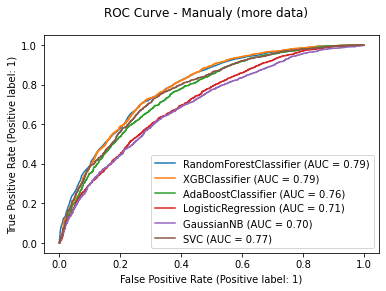

In [30]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_,xgb_,ada_,lr_,gnb_,svm_]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Manualy (more data)');

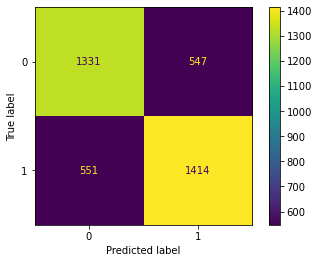

In [36]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc_, X_test, Y_test)

## Models 

In [31]:
cv = KFold(n_splits=10, random_state= 42 ,shuffle=True)

### Random Forest (UnderSampling)

In [32]:
scores = cross_val_score(rfc_, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [33]:
print ("Random Forest Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= rfc_.predict(X_test)


print("Random Forest Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Random Forest Mean ROC AUC Training Set  0.7865808046919913

Random Forest Mean ROC AUC Testing Set  0.7141627848368819


In [34]:
Y_pred = rfc_.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1878
           1       0.72      0.72      0.72      1965

    accuracy                           0.71      3843
   macro avg       0.71      0.71      0.71      3843
weighted avg       0.71      0.71      0.71      3843



### Gaussian NB (UnderSampling)

In [178]:
scores = cross_val_score(gnb_, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [179]:
print ("Gaussian NB Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= gnb_.predict(X_test)


print("Gaussian NB Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Gaussian NB Mean ROC AUC Training Set  0.7050580239420297

Gaussian NB Mean ROC AUC Testing Set  0.6091444528449137


In [180]:
Y_pred = gnb_.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.38      0.49      1878
           1       0.59      0.84      0.69      1965

    accuracy                           0.61      3843
   macro avg       0.64      0.61      0.59      3843
weighted avg       0.64      0.61      0.59      3843



### Support Vector Machine (UnderSampling)

In [120]:
scores = cross_val_score(svm_, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [121]:
print ("Support Vector Machine Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= svm_.predict(X_test)


print("Support Vector Machine Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Random Forest Mean ROC AUC Training Set  0.7687670481471399

Random Forest Mean ROC AUC Testing Set  0.6918192977749597


In [122]:
Y_pred = svm_.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67      1878
           1       0.68      0.75      0.72      1965

    accuracy                           0.69      3843
   macro avg       0.70      0.69      0.69      3843
weighted avg       0.69      0.69      0.69      3843



### XGboost (UnderSampling)

In [181]:
scores = cross_val_score(xgb_, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [182]:
print ("XGboost Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= xgb_.predict(X_test)


print("XGboost Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

XGboost Mean ROC AUC Training Set  0.7835258815656678

XGboost Mean ROC AUC Testing Set  0.7091416075246527


In [183]:
Y_pred = xgb_.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      1878
           1       0.71      0.74      0.72      1965

    accuracy                           0.71      3843
   macro avg       0.71      0.71      0.71      3843
weighted avg       0.71      0.71      0.71      3843



### Adaboost (UnderSampling)

In [184]:
scores = cross_val_score(ada_, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

In [185]:
print ("Adaboost Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= ada_.predict(X_test)


print("Adaboost Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Adaboost Mean ROC AUC Training Set  0.7558400007991195

Adaboost Mean ROC AUC Testing Set  0.6841787999252087


In [186]:
Y_pred = ada_.predict(X_test)


print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.69      0.64      0.67      1878
           1       0.68      0.73      0.70      1965

    accuracy                           0.69      3843
   macro avg       0.69      0.68      0.68      3843
weighted avg       0.69      0.69      0.68      3843



In [55]:
gbm = xgb.XGBClassifier(objective = "binary:logistic",
                        learning_rate = 0.1,
                        n_estimators = 70,
                        max_depth = 6,
                        min_child_weight = 5,
                        gamma = 0.3,
                        colsample_bytree = 0.65,
                        subsample = 0.75,
                        reg_alpha = 0.5)
                        
                        

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)
fit_model = gbm.fit(X_train, Y_train) #gives output log as below



print('\n',"Train Score: ",fit_model.score(X_train, Y_train),'\n',"Test Score: ",fit_model.score(X_test, Y_test) )
Y_pred = fit_model.predict(X_test)

[09:45:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Train Score:  0.7700865265760197 
 Test Score:  0.697632058287796


In [56]:
print(classification_report(Y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      1730
           1       0.75      0.68      0.71      2113

    accuracy                           0.70      3843
   macro avg       0.70      0.70      0.70      3843
weighted avg       0.70      0.70      0.70      3843



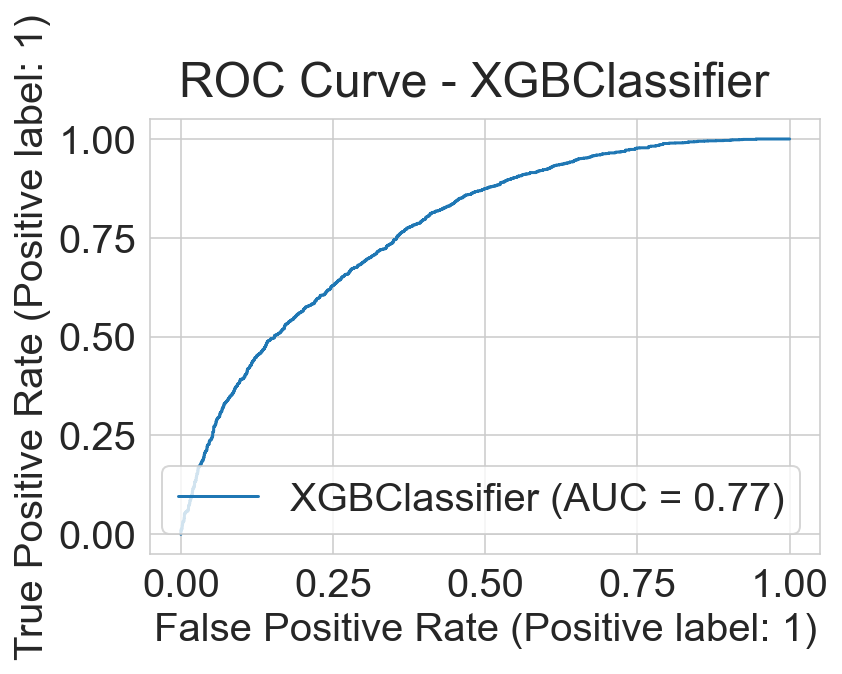

In [57]:
fig, ax1 = plt.subplots(1,1)
for mod in [fit_model]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - XGBClassifier');

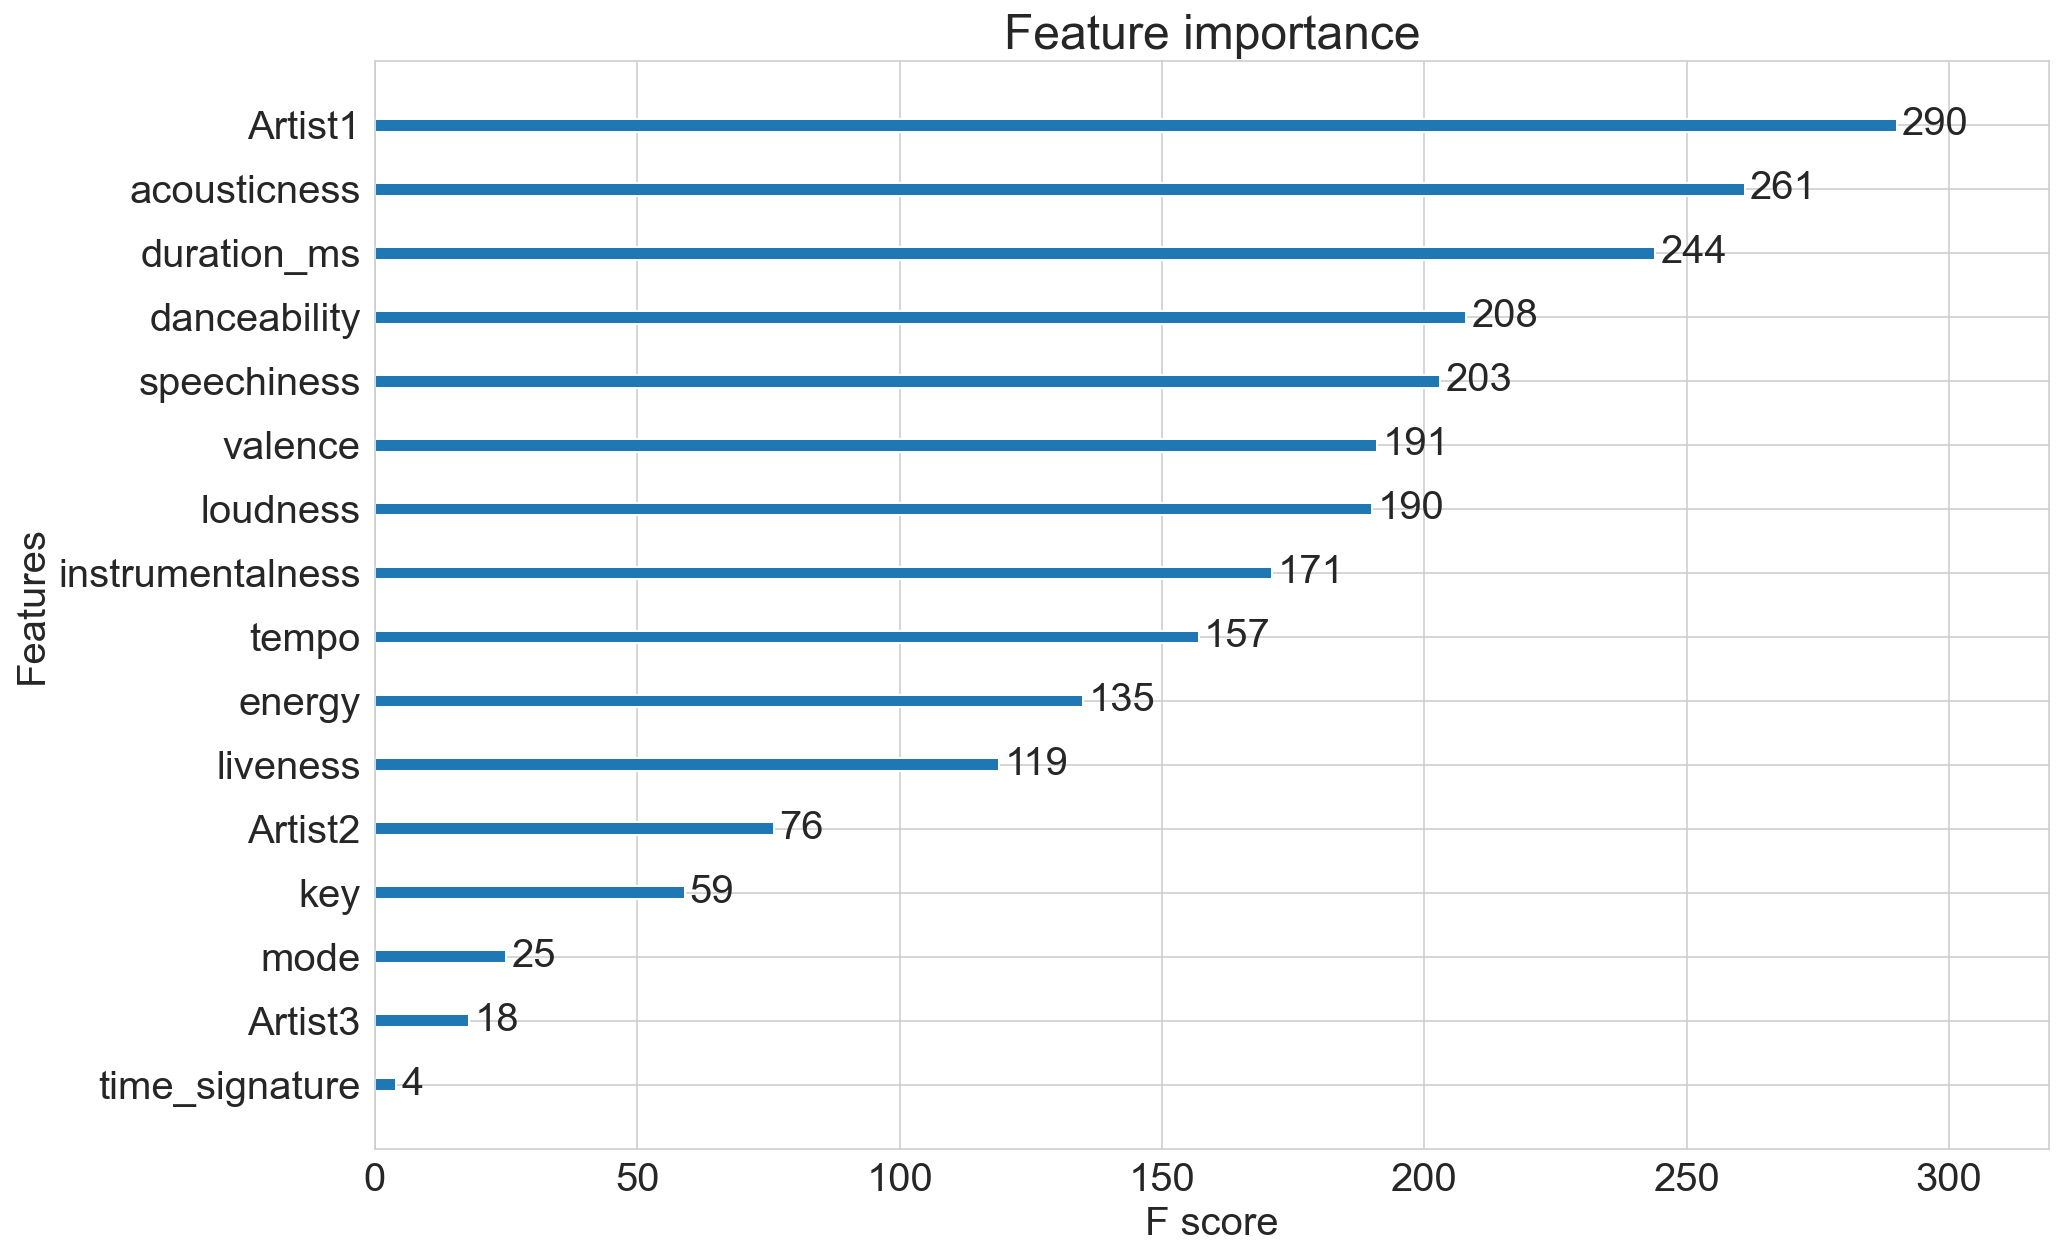

In [58]:
# xgb.plot_importance(gbm, importance_type='weight')
plt.rcParams.update({'font.size': 20})
ax = xgb.plot_importance(fit_model, importance_type='weight')
fig = ax.figure
fig.set_size_inches(15, 10)

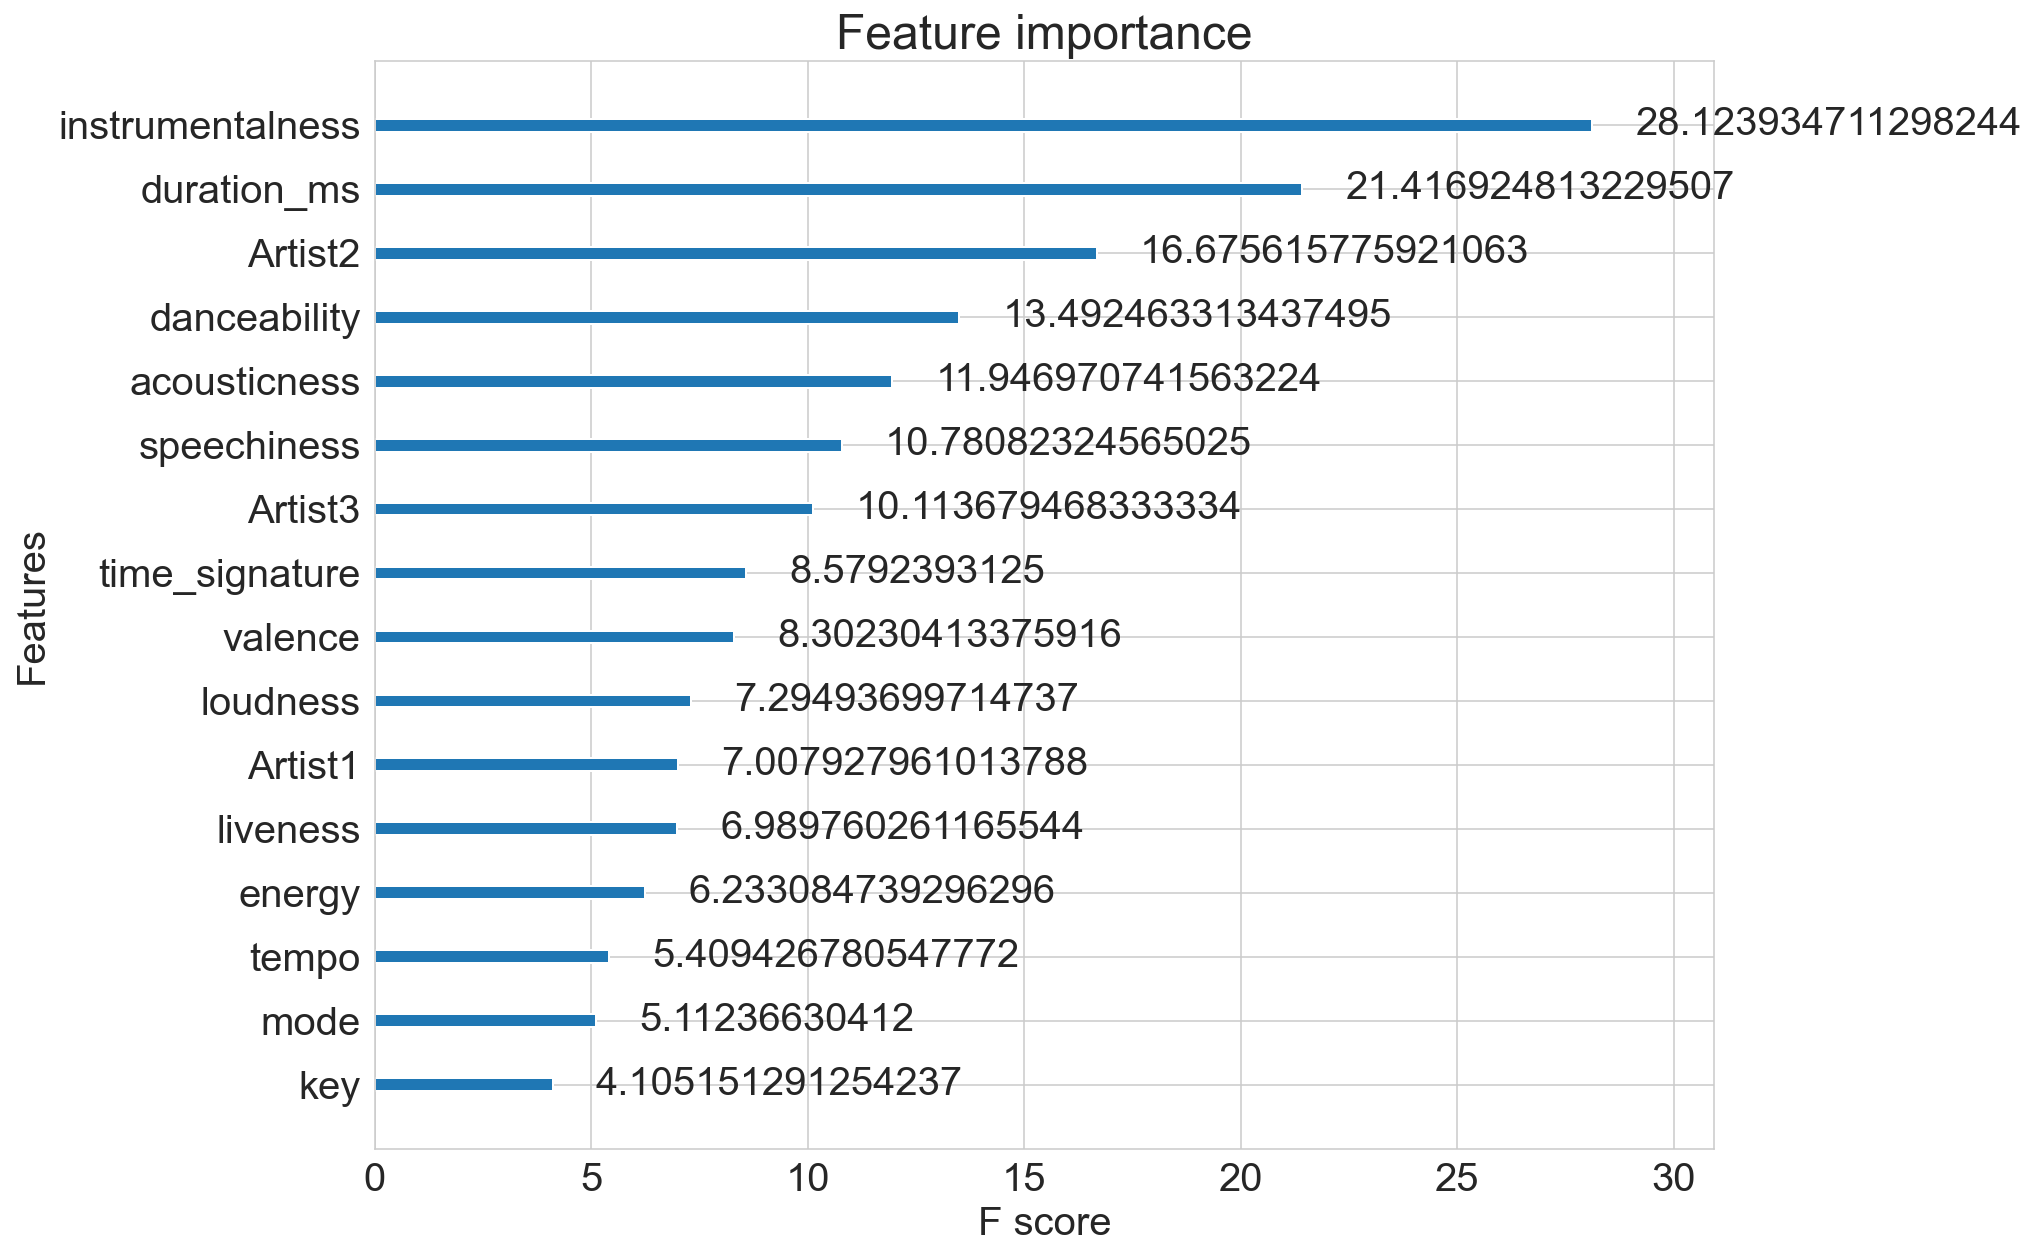

In [59]:
# xgb.plot_importance(gbm, importance_type='weight')
plt.rcParams.update({'font.size': 20})
ax = xgb.plot_importance(fit_model, importance_type='gain')
fig = ax.figure
fig.set_size_inches(12, 10)

In [60]:
Weights = pd.DataFrame(fit_model.get_booster().get_score(importance_type='weight'),index=[0])
Weights.index = ['Weight']
Weights = Weights.T
Weights.sort_values(by = 'Weight', ascending = False, inplace = True)
Weights.head()

,Weight
Artist1,290
acousticness,261
duration_ms,244
danceability,208
speechiness,203


In [61]:
Gain = pd.DataFrame(fit_model.get_booster().get_score(importance_type='gain'),index=[0])
Gain.index = ['Accuracy_Gain']
Gain = Gain.T
Gain.sort_values(by = 'Accuracy_Gain', ascending = False, inplace = True)
Gain.head()

,Accuracy_Gain
instrumentalness,28.123935
duration_ms,21.416925
Artist2,16.675616
danceability,13.492463
acousticness,11.946971


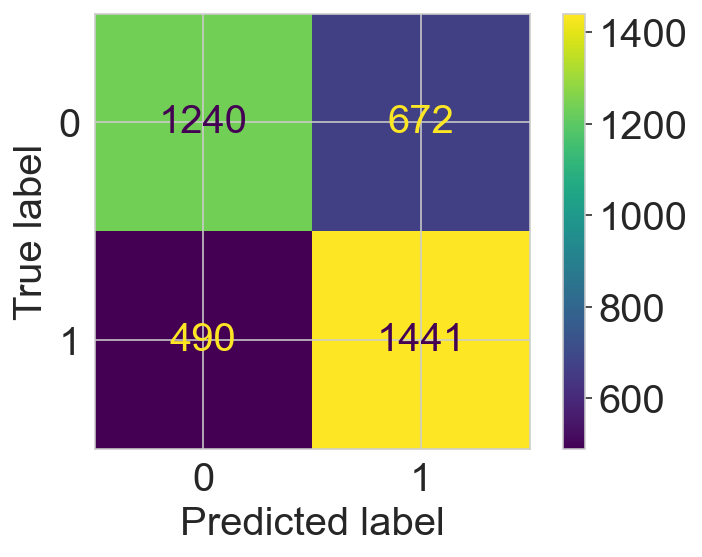

In [62]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(fit_model, X_test, Y_test)

# Tuning parameters using Gridsearch CV

## Random Forest Gridsearch CV

In [138]:
param_grid = { 
    'n_estimators': [100,500,1000],
    'max_features': ['auto','sqrt',10,8],
    'max_depth' : [5,8,10,12,15],
    'criterion' :['gini', 'entropy']
    }

In [140]:

# CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= cv, scoring='roc_auc')

# CV_rfc.fit(X_train,Y_train)

# CV_rfc.best_params_


{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 1000}

In [141]:
# print ("Random Forest Gird Mean ROC AUC Training Set ", CV_rfc.best_score_)
# print()

# Y_pred= CV_rfc.predict(X_test)


# print("Random Forest Gird  Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Random Forest Gird Mean ROC AUC Training Set  0.7895178587654972

Random Forest Gird  Mean ROC AUC Testing Set  0.7006877545545449


              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1878
           1       0.69      0.75      0.72      1965

    accuracy                           0.70      3843
   macro avg       0.70      0.70      0.70      3843
weighted avg       0.70      0.70      0.70      3843



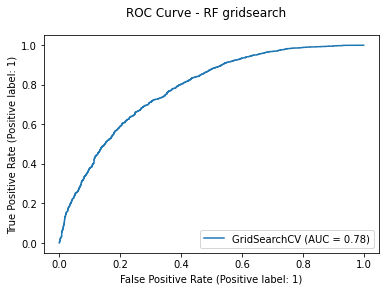

In [142]:
# print(classification_report(Y_test, Y_pred))


# fig, ax1 = plt.subplots(1,1)
# for mod in [CV_rfc]:
#     metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
# plt.suptitle('ROC Curve - RF gridsearch');

In [38]:
rfc_best = RandomForestClassifier(n_estimators=1000 ,max_depth=20)

scores = cross_val_score(rfc_best, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

rfc_best.fit(X_train,Y_train)

print ("Random Forest Gird Mean ROC AUC Training Set ", np.mean(scores))
print()

Y_pred= rfc_best.predict(X_test)


print("Random Forest Gird  Mean ROC AUC Testing Set " ,roc_auc_score(Y_test, Y_pred))

Random Forest Gird Mean ROC AUC Training Set  0.7895135093127363

Random Forest Gird  Mean ROC AUC Testing Set  0.721595980781894


              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1878
           1       0.72      0.74      0.73      1965

    accuracy                           0.72      3843
   macro avg       0.72      0.72      0.72      3843
weighted avg       0.72      0.72      0.72      3843



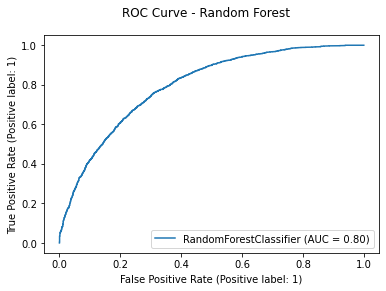

In [39]:
print(classification_report(Y_test, Y_pred))


fig, ax1 = plt.subplots(1,1)
for mod in [rfc_best]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Random Forest');

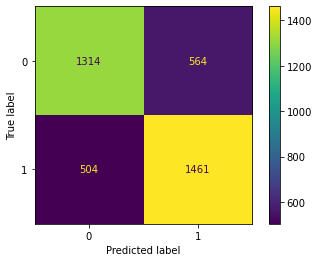

In [40]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rfc_best, X_test, Y_test)

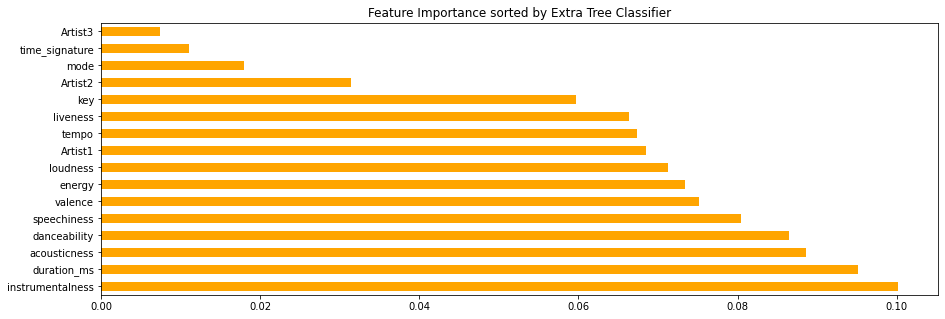

In [134]:
X = spotify_songs_added[['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]                                         

y = spotify_songs_added['Hit or not']

model = ExtraTreesClassifier(n_estimators=100, random_state=42)

model.fit(X,y)

plt.figure(figsize=(15,5))

feat_importances = pd.Series(model.feature_importances_, index=X.columns)

feat_importances.nlargest(16).plot(kind='barh',color="orange")

plt.title('Feature Importance sorted by Extra Tree Classifier')

plt.show()
